<a href="https://colab.research.google.com/github/nedelculiviu95/cnn-detecting-lung-opacities/blob/master/prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install pydicom

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
    100% |████████████████████████████████| 7.0MB 6.1MB/s 


In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import glob
import pylab
import matplotlib.pyplot as plt
import random
from random import randint
from pathlib import Path
import os
import pydicom
from skimage import measure
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
import keras
import csv
import re

In [0]:
LR = 0.005
EPOCHS = 40
BATCHSIZE = 32
CHANNELS = 64
IMAGE_SIZE = 256
NBLOCK = 6 
DEPTH = 2
MOMENTUM = 0.9

In [0]:
# LOAD PNEUMONIA LOCATIONS

# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('/content/gdrive/My Drive/train_images/stage_1_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [8]:
# Load filenames

# load and shuffle filenames
folder = '/content/gdrive/My Drive/train_images/stage_1_train_images/'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 300
n_train_examples = 3000
train_filenames = filenames[0:n_train_examples]
valid_filenames = filenames[n_train_examples:n_valid_samples+n_train_examples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples
print(train_filenames[0])

n train samples 3000
n valid samples 300
5dff6446-bad1-4a42-af53-b02cd1e51b71.dcm


In [0]:
# Data generator
# generate your dataset on multiple cores in real time and feed it right away to your deep learning model
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=BATCHSIZE, 
                 image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
    
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # default negative
        target = 0
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in pneumonia_locations:
            target = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
        # add trailing channel dimension
        
        img = np.expand_dims(img, -1)
        return img, target
      
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
      
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, targets = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            targets = np.array(targets)
            return imgs, targets
#Shuffling the order in which examples are fed to the classifier is helpful 
#so that batches between epochs do not look alike. Doing so will eventually make our model more robust.
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [0]:
# Network

def convlayer(channels, inputs, size=3, padding='same'):
    #Normalize the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1
    x = keras.layers.BatchNormalization(momentum=MOMENTUM)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, size, padding=padding, use_bias=False)(x)
    return x

def just_downsample(inputs, pool=2):
    x = keras.layers.BatchNormalization(momentum=MOMENTUM)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.MaxPool2D(pool)(x)
    return x

def convblock(inputs, channels1, channels2):
    x = convlayer(channels1, inputs)
    x = convlayer(channels2, x)
    x = keras.layers.Concatenate()([inputs, x])
    return x
  
def denseblock(inputs, nblocks=6, channels1=128, channels2=32):
    x = inputs
    for i in range(nblocks):
        x = convblock(x, channels1, channels2)
    x = keras.layers.SpatialDropout2D(.2)(x)
    return x

def transition(inputs, channels, pool=2):
    x = convlayer(channels, inputs)
    x = keras.layers.AveragePooling2D(pool)(x)
    return x

def create_network(input_size, channels=64, channels2=32, n_blocks=NBLOCK, depth=DEPTH):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', strides=2, use_bias=False)(inputs)
    x = just_downsample(x)

    # densenet blocks
    nchan = channels
    for d in range(depth-1):
        x = denseblock(x)
        nchan = ( nchan + n_blocks*channels2 ) // 2
        x = transition(x, nchan)
    x = denseblock(x)

    # output
    x = convlayer(channels, x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Dropout(.5)(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=inputs, outputs=output)
    return model

In [11]:
# create network and compiler
model = create_network(input_size=IMAGE_SIZE, channels=CHANNELS, n_blocks=NBLOCK, depth=DEPTH)
#103 layers
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 576         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 128, 128, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [0]:
model.compile(optimizer=keras.optimizers.Adam(lr=LR),
              loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [18]:
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCHSIZE, 
                      image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCHSIZE, 
                      image_size=IMAGE_SIZE, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, 
                              epochs=EPOCHS, shuffle=True, verbose=2)

Epoch 1/40
 - 132s - loss: 0.4418 - acc: 0.7927 - val_loss: 0.5505 - val_acc: 0.7569
Epoch 2/40
 - 130s - loss: 0.4406 - acc: 0.7876 - val_loss: 0.5038 - val_acc: 0.7431
Epoch 3/40
 - 130s - loss: 0.4411 - acc: 0.7923 - val_loss: 0.5333 - val_acc: 0.7431
Epoch 4/40
 - 130s - loss: 0.4395 - acc: 0.7974 - val_loss: 0.4965 - val_acc: 0.7222
Epoch 5/40
 - 130s - loss: 0.4410 - acc: 0.7947 - val_loss: 0.4961 - val_acc: 0.7708
Epoch 6/40
 - 129s - loss: 0.4438 - acc: 0.7950 - val_loss: 0.7991 - val_acc: 0.5000
Epoch 7/40
 - 131s - loss: 0.4318 - acc: 0.8021 - val_loss: 0.5226 - val_acc: 0.7639
Epoch 8/40
 - 130s - loss: 0.4336 - acc: 0.7984 - val_loss: 0.5406 - val_acc: 0.7049
Epoch 9/40
 - 130s - loss: 0.4305 - acc: 0.7944 - val_loss: 0.5394 - val_acc: 0.7500
Epoch 10/40
 - 131s - loss: 0.4375 - acc: 0.7913 - val_loss: 0.4870 - val_acc: 0.7535
Epoch 11/40
 - 129s - loss: 0.4357 - acc: 0.7947 - val_loss: 0.5231 - val_acc: 0.7465
Epoch 12/40
 - 129s - loss: 0.4307 - acc: 0.7991 - val_loss: 0.

# Testing 

Ground truth: patient 57a3b6a4-4b5d-4436-b526-275ba2586b46 has pneumonia
(1, 256, 256, 1)


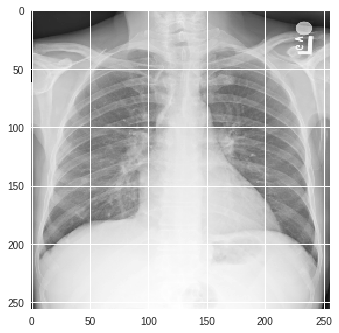

In [77]:
filename = filenames[4004]
img = pydicom.dcmread(os.path.join('/content/gdrive/My Drive/train_images/stage_1_train_images/', filename)).pixel_array
groundTruth = 0
# resize both image and mask
img = resize(img, (256,256 ), mode='reflect')

pylab.imshow(img, cmap=pylab.cm.gist_gray)

# add trailing channel dimension
img = np.expand_dims(img, -1)

filename = re.sub('\.dcm$', '', filename)
with open(os.path.join('/content/gdrive/My Drive/train_images/stage_1_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        csv_filename = rows[0]
        csv_location = rows[1:5]
        csv_pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if csv_filename == filename:
          # 0 - no pneumonia or another issue, 1 - pneumonia
          if csv_pneumonia == '1':
            print("Ground truth: patient",filename, "has pneumonia")
          else:
            print("Ground truth: patient",filename, "doesn't have pneumonia")

img = np.expand_dims(img, 0)
print(img.shape)



In [76]:
#testing if img has pneumonia or not 
feature = model.predict(img)
print(feature)
if feature[0][0] > 0.5:
  print("Prediction: patient",filename, "has pneumonia")
else:
  print("Prediction: patient",filename, "does't have pneumonia")

[[0.8578906]]
Prediction: patient 57a3b6a4-4b5d-4436-b526-275ba2586b46 has pneumonia


#Plotting training and validation matrics

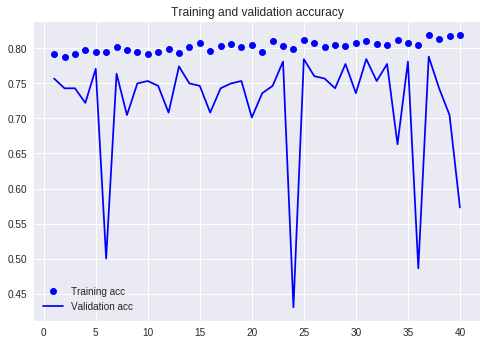

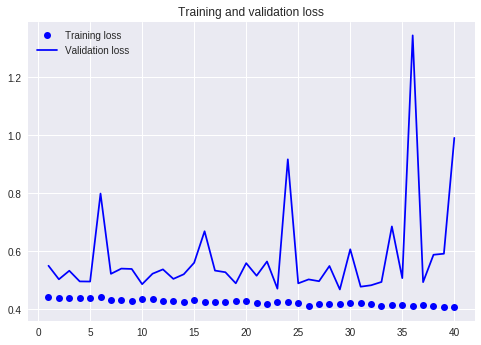

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


#Observations 

###1) Training data: 1000 train, Validation data: 300
3 epochs, 103 layers, image_size = 256, optimizers.Adam(lr=LR), batches_size = 32 
 - 634s - loss: 0.5637 - acc: 0.7419 - val_loss: 1.0612 - val_acc: 0.7639
 - 52s - loss: 0.5030 - acc: 0.7792 - val_loss: 0.6660 - val_acc: 0.7778
 - 47s - loss: 0.5094 - acc: 0.7782 - val_loss: 0.5058 - val_acc: 0.7778
 
 ***************************************************************************************************
10 epochs, 103 layers, image_size = 224, optimizers.Adam(lr=LR), batches_size = 32
 - 47s - loss: 0.4918 - acc: 0.7772 - val_loss: 0.6629 - val_acc: 0.5868
 - 45s - loss: 0.4974 - acc: 0.7722 - val_loss: 0.5825 - val_acc: 0.7604
 - 46s - loss: 0.4787 - acc: 0.7762 - val_loss: 0.8144 - val_acc: 0.7674
 - 46s - loss: 0.4796 - acc: 0.7722 - val_loss: 0.5587 - val_acc: 0.7674
 - 45s - loss: 0.4789 - acc: 0.7823 - val_loss: 5.4953 - val_acc: 0.2326
 - 46s - loss: 0.4552 - acc: 0.7883 - val_loss: 0.5697 - val_acc: 0.7639
 - 45s - loss: 0.4705 - acc: 0.7802 - val_loss: 0.5766 - val_acc: 0.7639
 - 46s - loss: 0.4639 - acc: 0.7782 - val_loss: 0.5650 - val_acc: 0.7743
 - 45s - loss: 0.4494 - acc: 0.7802 - val_loss: 0.9516 - val_acc: 0.2778
 - 45s - loss: 0.4735 - acc: 0.7732 - val_loss: 0.5105 - val_acc: 0.7743
 
 ***************************************************************************************************
10 epochs, 103 layers, image_size = 256, optimizers.Adam(lr=LR), batches_size = 32

  - 572s - loss: 0.5815 - acc: 0.6996 - val_loss: 0.6140 - val_acc: 0.6493
  - 50s - loss: 0.5386 - acc: 0.7651 - val_loss: 0.5859 - val_acc: 0.7535
  - 47s - loss: 0.5263 - acc: 0.7601 - val_loss: 0.5462 - val_acc: 0.7500
  - 48s - loss: 0.4990 - acc: 0.7692 - val_loss: 0.6374 - val_acc: 0.7535
  - 47s - loss: 0.5010 - acc: 0.7692 - val_loss: 0.7085 - val_acc: 0.7500
  - 48s - loss: 0.5101 - acc: 0.7560 - val_loss: 0.6044 - val_acc: 0.7257
  - 47s - loss: 0.4929 - acc: 0.7671 - val_loss: 0.5542 - val_acc: 0.7361
  - 47s - loss: 0.4896 - acc: 0.7722 - val_loss: 0.6344 - val_acc: 0.7535
  - 48s - loss: 0.4956 - acc: 0.7601 - val_loss: 0.8351 - val_acc: 0.4132
  - 48s - loss: 0.4928 - acc: 0.7631 - val_loss: 0.5157 - val_acc: 0.7569
  
  

###2) Training data: 3000 train, Validation data: 300
20 epochs, 103 layers, image_size = 256, optimizers.Adam(lr=LR), batches_size = 32 
 - 984s - loss: 0.5434 - acc: 0.7413 - val_loss: 0.5556 - val_acc: 0.7361
 - 135s - loss: 0.5042 - acc: 0.7745 - val_loss: 0.5265 - val_acc: 0.7396
 - 129s - loss: 0.4875 - acc: 0.7745 - val_loss: 0.7736 - val_acc: 0.7257
 - 129s - loss: 0.4790 - acc: 0.7752 - val_loss: 0.5280 - val_acc: 0.7118
 - 130s - loss: 0.4694 - acc: 0.7732 - val_loss: 0.8569 - val_acc: 0.7396
 - 130s - loss: 0.4708 - acc: 0.7715 - val_loss: 0.4995 - val_acc: 0.7639
 - 130s - loss: 0.4645 - acc: 0.7786 - val_loss: 0.5144 - val_acc: 0.7222
 - 130s - loss: 0.4655 - acc: 0.7876 - val_loss: 0.4983 - val_acc: 0.7465
 - 130s - loss: 0.4578 - acc: 0.7722 - val_loss: 0.5716 - val_acc: 0.7396
 - 130s - loss: 0.4546 - acc: 0.7826 - val_loss: 0.4964 - val_acc: 0.7396
 - 130s - loss: 0.4607 - acc: 0.7796 - val_loss: 0.5167 - val_acc: 0.7361
 - 129s - loss: 0.4509 - acc: 0.7923 - val_loss: 0.5206 - val_acc: 0.7535
 - 130s - loss: 0.4487 - acc: 0.7917 - val_loss: 0.5064 - val_acc: 0.7743
 - 131s - loss: 0.4483 - acc: 0.7823 - val_loss: 0.5172 - val_acc: 0.7465
 - 131s - loss: 0.4473 - acc: 0.7893 - val_loss: 0.4948 - val_acc: 0.7778
 - 132s - loss: 0.4460 - acc: 0.7883 - val_loss: 0.5140 - val_acc: 0.7639
 - 130s - loss: 0.4398 - acc: 0.7960 - val_loss: 0.4835 - val_acc: 0.7674
 - 131s - loss: 0.4379 - acc: 0.7984 - val_loss: 0.5306 - val_acc: 0.7743
 - 130s - loss: 0.4438 - acc: 0.7880 - val_loss: 0.5616 - val_acc: 0.7014
 - 130s - loss: 0.4440 - acc: 0.7984 - val_loss: 0.4800 - val_acc: 0.7882
 

***************************************************************************************************
40 epochs, 103 layers, image_size = 256, optimizers.Adam(lr=LR), batches_size = 32



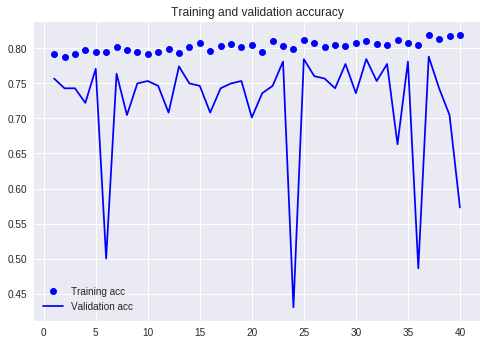

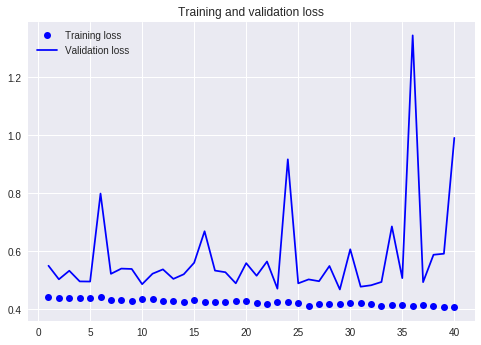

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()